### Problem:
The images are in different orientations: upright, rotated_right , rotated_left ,upside_down and upright .

### Solution: 
A neural network must be trained to solve the test problem. There is a train.csv file that contains a column called label (the learning algorithm) and in the fn column the name of the file (extraction of characteristics). The images must be opened as a vector, so that NN can obtain the characteristics. In this case, supervised learning should be used due to needing to learn the difference between the positions of the images.

# Attempt 1- Image classification from keras

### 1-) Import Library

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import gc
%matplotlib inline

### 2-) Read and View the Data

In [61]:
train_imgs = pd.read_csv('./train.csv')

In [62]:
# Check data
train_imgs.head(5)

,fn,label
0,0-10049200_1891-09-16_1958.jpg,rotated_left
1,0-10110600_1985-09-17_2012.jpg,rotated_left
2,0-10126400_1964-07-07_2010.jpg,upright
3,0-1013900_1917-10-15_1960.jpg,rotated_right
4,0-10166400_1960-03-12_2008.jpg,upside_down


In [63]:
# Check data
train_imgs.tail(5)

,fn,label
48891,89-9693789_1941-01-11_1973.jpg,upright
48892,89-9719989_1985-04-13_2004.jpg,rotated_left
48893,89-981289_1962-12-23_2009.jpg,rotated_left
48894,89-9921189_1983-11-25_2013.jpg,rotated_left
48895,89-9954489_1927-03-13_1977.jpg,rotated_right


In [64]:
len(train_imgs['fn'])

48896

View images first 5 image

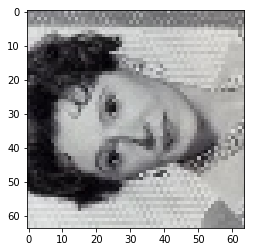

(64, 64, 3)


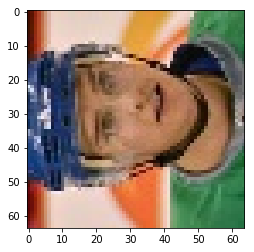

(64, 64, 3)


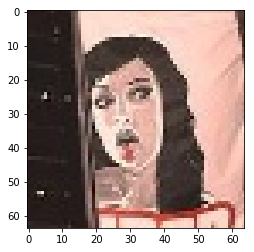

(64, 64, 3)


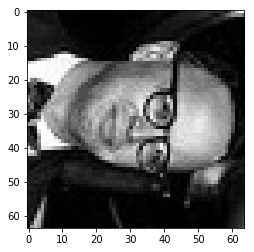

(64, 64, 3)


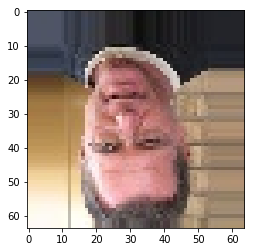

(64, 64, 3)


In [65]:
for ima in train_imgs['fn'][0:5]:
    img = mpimg.imread('./train/'+ima)
    imgplot = plt.imshow(img)
    plt.show()
    print(img.shape)

### 3-) Organize the Data

Function to separate the characteristics of the images of the learning

In [66]:
def read_and_process_image(lista_img,lista_lab):
    X = []
    y =[]
    for image,label in zip(lista_img,lista_lab):
        X.append(mpimg.imread('./train/'+image))# add image to array
        
        """Change string to int:
        
        upright = 0,
        
        right = 1,
        
        left = 2,
        
        upside down =3"""
        
        if 'upright' in label:
            y.append(0)
        elif 'rotated_right' in label:
            y.append(1)
        elif 'rotated_left' in label:
            y.append(2)
        elif 'upside_down' in label:
            y.append(3)
        else:
            y.append(None)
    return X,y

Add datas in X and y variable

In [67]:
X,y = read_and_process_image(train_imgs['fn'][0:10000],train_imgs['label'][0:10000])

In [68]:
# turn into Array
X = np.array(X)
y = np.array(y)

In [69]:
# X => (img number, rowns, coloumns,layers)
X.shape

(500, 64, 64, 3)

In [70]:
# y => (values of img orientation)
y.shape

(500,)

In [71]:
# deleting unnecessary variables.
del train_imgs
gc.collect()

11682

### 4-)  Split  the Data with sklearn
splitting data arrays into two subsets

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,#20% reserved to test
    random_state =2
)

In [74]:
# deleting unnecessary variables again.
del X
del y
gc.collect()

0

In [75]:
X_train.shape, y_train.shape

((400, 64, 64, 3), (400,))

In [76]:
X_test.shape, y_test.shape

((100, 64, 64, 3), (100,))

### 5-) starting training

In [28]:
from keras import (
    layers,# Contains different types of layers used in deep learning, such as, Convolutional
    models,# Sequential will be used
    optimizers# back propagation algorithm (we will use Adams)
)

from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


begin create the model

In [59]:
def create_model():
    
    model = models.Sequential()
    model.add(layers.Conv2D(filters = 32,kernel_size=(3,3),activation = 'relu',input_shape=(64,64,3)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64,(3,3),activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128,(3,3),activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128,(3,3),activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten()) #Convert matrix to array (input data)
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dense(4, activation = 'softmax'))# we will use 'softmax' because 4 position possibilities
    
    return model

In [31]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 128)        

In [32]:
#parameters to the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "Adam",metrics = ['accuracy'])

In [78]:
#Length
ntrain = len(X_train)
ntest = len(X_test)

#2^n...2..4..8..16..32..64..
batch_size =128

ntrain,ntest

(400, 100)

In [34]:
def gerador(X_train,X_test,y_train,y_test):
    # Normalizate the image [between 0 and 255] to [between 0 and 1]
    train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 0,
        width_shift_range = 0.2,
        height_shift_range= 0.2,
        shear_range= 0.2,
        zoom_range= 0.2,
        horizontal_flip=True,
    )

    test_datagen = ImageDataGenerator(rescale = 1./255) #Rescale
    
    # Create the image generators
    train_generator = train_datagen.flow(X_train,y_train,batch_size = batch_size)
    val_generator = test_datagen.flow(X_test,y_test,batch_size = batch_size)
    
    return train_generator, val_generator


train_generator,test_generator = gerador(X_train,X_test,y_train,y_test)

In [35]:
def train(epoch):
    history = model.fit_generator(
    train_generator,
    steps_per_epoch = ntrain // batch_size,
    epochs = epoch,
    validation_data = test_generator,
    validation_steps = ntest // batch_size
    )
    
    return history

In [81]:
history = train(40)

Epoch 1/40
125/125 [==============================] - 43s 343ms/step - loss: 1.3727 - accuracy: 0.2797 - val_loss: 1.2319 - val_accuracy: 0.4395
Epoch 2/40
125/125 [==============================] - 42s 333ms/step - loss: 1.1402 - accuracy: 0.4624 - val_loss: 0.9396 - val_accuracy: 0.5950
Epoch 3/40
125/125 [==============================] - 43s 343ms/step - loss: 0.9462 - accuracy: 0.5476 - val_loss: 0.6180 - val_accuracy: 0.6508
Epoch 4/40
125/125 [==============================] - 43s 340ms/step - loss: 0.8299 - accuracy: 0.5974 - val_loss: 0.6666 - val_accuracy: 0.6348
Epoch 5/40
125/125 [==============================] - 44s 348ms/step - loss: 0.7707 - accuracy: 0.6062 - val_loss: 0.6160 - val_accuracy: 0.6756
Epoch 6/40
125/125 [==============================] - 41s 329ms/step - loss: 0.7195 - accuracy: 0.6310 - val_loss: 0.4882 - val_accuracy: 0.7025
Epoch 7/40
125/125 [==============================] - 40s 318ms/step - loss: 0.6842 - accuracy: 0.6409 - val_loss: 0.5549 - val_ac

#### Save Weight Model 

In [82]:
#model.save_weights('./save_weight_train/weight_01')

#### Plot

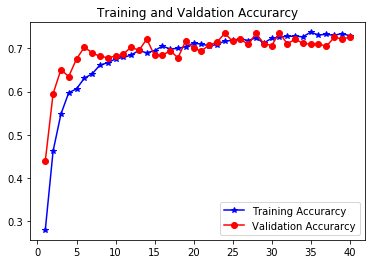

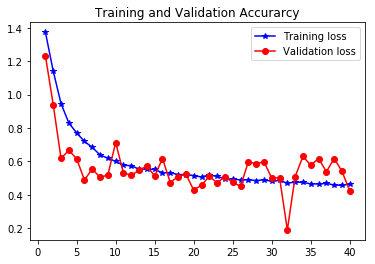

In [83]:
def plotar():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(acc)+1)

    plt.plot(epochs,acc,'*-b',label = 'Training Accurarcy')
    plt.plot(epochs,val_acc,'o-r',label = 'Validation Accurarcy')
    plt.title('Training and Valdation Accurarcy')
    plt.legend()

    plt.figure()
    plt.plot(epochs,loss,'*-b',label = 'Training loss')
    plt.plot(epochs,val_loss,'o-r',label = 'Validation loss')
    plt.title('Training and Validation Accurarcy')
    plt.legend()

    plt.show()
    
plotar()

# Attempt 2 - Continue

In [77]:
#model = create_model()

#model.load_weights('./save_weight_train/weight_01')

history = train(2)

Epoch 1/2
12/12 [==============================] - 126s 10s/step - loss: 0.4441 - accuracy: 0.7373 - val_loss: 0.4181 - val_accuracy: 0.7655
Epoch 2/2
12/12 [==============================] - 131s 11s/step - loss: 0.4363 - accuracy: 0.7463 - val_loss: 0.4242 - val_accuracy: 0.7624
